In [1]:
import u6
from time import sleep
from datetime import datetime
import traceback
import numpy as np
from scipy import signal
from scipy.fftpack import fft
from scipy import linspace,sqrt, exp,log #linspace allows us to generate linear array between start and stop points
import scipy.optimize as optimization #curve fitting
import matplotlib.pyplot as plt
#testing goodness of fit
from scipy.stats import chi2 
from scipy.stats import chisqprob 
#make pretty comments
from IPython.display import Latex 
#in case we want interactivity
from ipywidgets import interactive 
from ipywidgets import FloatProgress
from IPython.display import display
%pylab inline --no-import-all 
import h5py    # HDF5 support
d = u6.U6()

# Set up U6
d.configU6()

# For applying the proper calibration to readings.
d.getCalibrationData()

# Set the FIO0 to Analog
d.configIO()

Populating the interactive namespace from numpy and matplotlib


{'Counter0Enabled': False,
 'Counter1Enabled': False,
 'NumberTimersEnabled': 0,
 'TimerCounterPinOffset': 0}

In [2]:
# MAX_REQUESTS is the number of packets to be read.
MAX_REQUESTS =16
# the number of samples will be MAX_REQUESTS times 48 (packets per request) times 25 (samples per packet).

#Sample rate in Hz
SAMPLE_RATE=pow(2,12)

print "configuring U6 stream"
#d.streamConfig( NumChannels = 1,SamplesPerPacket=25,InternalStreamClockFrequency=1,DivideClockBy256=True, ResolutionIndex = 0 )
d.streamConfig( NumChannels = 2, ChannelNumbers = [ 0, 1 ], ChannelOptions = [ 0, 0 ], SettlingFactor = 0, ResolutionIndex = 0, ScanFrequency = SAMPLE_RATE )

configuring U6 stream


In [3]:
128*25*48


153600

In [4]:
def getFreq(y,Fs):
    
    n = len(y) # length of the signal
    w=signal.blackman(n)
    k = np.arange(n)

    T = 1.*n/Fs

    #print T
    frq = k/T # two sides frequency range
    frq = frq[range(n/2)] # one side frequency range
   
    Y = np.abs(fft(y*w)*10.) # fft computing and normalization
    max_index=np.argmax(Y[1:n/2])
    #max_frq=np.mean[frq[max_index-4:max_index+4]]
    
    #uncomment if we need to see plots of FFT for diagonosis
    #fig, axes=plt.subplots()
    #axes.plot(frq,Y[0:n/2])
    
    return (frq[max_index])

In [5]:
def getData():
    data1=np.array([],dtype=float)
    data2=np.array([],dtype=float)
    try:
       # print "start stream",
        d.streamStart()
        start = datetime.now()
        #print start
        
        missed = 0
        dataCount = 0
        packetCount = 0
    
        for r in d.streamData():
            if r is not None:
                # Our stop condition
                if dataCount >= MAX_REQUESTS:
                    break
                
                if r['errors'] != 0:
                    print "Error: %s ; " % r['errors'], datetime.now()
    
                if r['numPackets'] != d.packetsPerRequest:
                    print "----- UNDERFLOW : %s : " % r['numPackets'], datetime.now()
    
                if r['missed'] != 0:
                    missed += r['missed']
                    print "+++ Missed ", r['missed']
               
                data1=np.append(data1,r['AIN0'])
                data2=np.append(data2,r['AIN1'])
                dataCount += 1
                packetCount += r['numPackets']
            else:
                # Got no data back from our read.
                # This only happens if your stream isn't faster than the 
                # the USB read timeout, ~1 sec.
                print "No data", datetime.now()
    except:
        print "".join(i for i in traceback.format_exc())
    finally:
        stop = datetime.now()
        d.streamStop()
        
        #Find Frequency
        frq=getFreq(data1,SAMPLE_RATE)
        
        #Get power
        power=np.std(data2)
       
    return(frq,power)

In [6]:
# setDAC takes a voltage value, converts to 16 bit value, then puts
# outputs voltage to channel 0
def setDAC(Volts):
    bVolts=d.voltageToDACBits(Volts,dacNumber=0,is16Bits=True)
    d.getFeedback(u6.DAC16( 0,  bVolts))
    return

In [7]:
setDAC(0.)

In [8]:
# cycleData creates a table of voltages to output to DAC,
# wait for voltage to settle, and store rms value found at input
# variable rms stores the spectrum and is what is returned

def cycleData(lowV, HighV, numV):
    f = FloatProgress(min=0, max=numV)
    display(f)
    volts=np.linspace(lowV,HighV,numV)    
    power=np.array([],dtype=float)
    freq=np.array([],dtype=float)
    for i in volts:
        setDAC(i)
        sleep(.1)
        
        temp_freq,temp_power=getData()
        
        power=np.append(power,temp_power)
        freq=np.append(freq,temp_freq)
        f.value+=1
    return (power,freq)

In [9]:
def plotData(freq, power):
   
    fig, axes = plt.subplots(1,1)
    axes.plot(freq, power)
    
    axes.set_xlabel('frequency (Hz)')
    axes.set_ylabel('rms voltage (V)')


In [10]:
def _smooth(x, window_len=11, window='hanning'):
    """
    smooth the data using a window of the requested size.
    
    This method is based on the convolution of a scaled window on the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd 
            integer
        window: the type of window from 'flat', 'hanning', 'hamming', 
            'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t = linspace(-2,2,0.1)
    x = sin(t)+randn(len(t))*0.1
    y = _smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, 
    numpy.convolve, scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if a list instead of
    a string   
    """
    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."
 
    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."
    
    if window_len<3:
        return x
    
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise(ValueError,
            "Window is not one of '{0}', '{1}', '{2}', '{3}', '{4}'".format(
            *('flat', 'hanning', 'hamming', 'bartlett', 'blackman')))
    
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = eval('np.' + window + '(window_len)')
 
    y = np.convolve(w / w.sum(), s, mode = 'valid')
    return y
    

949.76
1390.08


50

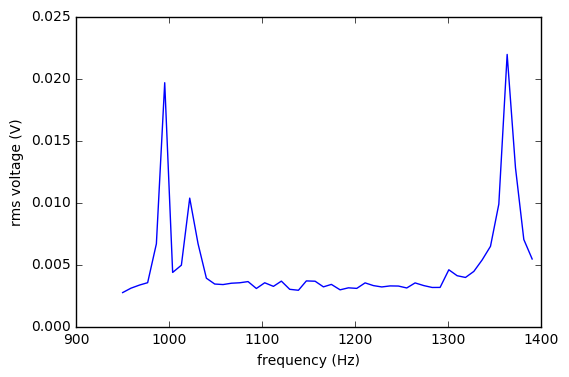

In [29]:
#take spectrum
spectrum,freq=cycleData(0.01,2.0,50)
plotData(freq,spectrum)
print freq[0]
print freq[-1]
setDAC(0)
len(freq)

In [58]:



print "Write a NeXus HDF5 file"
filedate='{:%Y-%m-%d-%H%M}'.format(datetime.now())
fileName=format('ConfigA-%s-%s-%s.hdf5' % (int(freq[0]), int(freq[-1]),blah))


# load data from two column format
data=np.column_stack((freq[:,np.newaxis],spectrum[:,np.newaxis])).T
#data = numpy.loadtxt('test.dat',delimiter=',').T
mr_arr = data[1]
#i00_arr = numpy.asarray(data[1],'int32')
i00_arr=data[0]
# create the HDF5 NeXus file
f = h5py.File(fileName, "w")
# point to the default data to be plotted
f.attrs['default']          = 'entry'
# give the HDF5 root some more attributes
f.attrs['file_name']        = fileName
f.attrs['file_time']        = filedate
f.attrs['instrument']       = 'APS USAXS at 32ID-B'
f.attrs['creator']          = 'BasicWriter.py'
f.attrs['NeXus_version']    = '4.3.0'
f.attrs['HDF5_Version']     = h5py.version.hdf5_version
f.attrs['h5py_version']     = h5py.version.version

# create the NXentry group
nxentry = f.create_group('entry')
nxentry.attrs['NX_class'] = 'NXentry'
nxentry.attrs['default'] = 'mr_scan'
nxentry.create_dataset('title', data='1-D scan of I00 v. mr')

# create the NXentry group
nxdata = nxentry.create_group('mr_scan')
nxdata.attrs['NX_class'] = 'NXdata'
nxdata.attrs['signal'] = 'Intensity'      # Y axis of default plot
nxdata.attrs['frequency'] = 'mr'         # X axis of default plot
nxdata.attrs['mr_indices'] = [0,]   # use "mr" as the first dimension of I00

# X axis data
ds = nxdata.create_dataset('mr', data=mr_arr)
ds.attrs['units'] = 'frequency'
ds.attrs['long_name'] = 'frequency (Hz)'    # suggested X axis plot label

# Y axis data
ds = nxdata.create_dataset('I00', data=i00_arr)
ds.attrs['units'] = 'counts'
ds.attrs['long_name'] = 'Intensity V'    # suggested Y axis plot label

f.close()   # be CERTAIN to close the file

print "wrote file:", fileName

Write a NeXus HDF5 file
wrote file: ConfigA-949-1390-2016-10-21-1125.hdf5


In [55]:
data_out=np.column_stack((freq[:,np.newaxis],spectrum[:,np.newaxis]))
np.savetxt('configA-74-95-072316a.dat', data_out, delimiter=',')

In [ ]:
data_out=np.column_stack((freq[:,np.newaxis],spectrum[:,np.newaxis]))
np.savetxt('configA-4-333-071615.dat', data_out, delimiter=',')

In [40]:
d.close()

In [ ]:
index=_smooth(spectrum,1)
d=np.diff(index)
dd=np.diff(d)
v=np.sign(d[:len(freq)])

resonances = freq[[np.where((v[:-1]!=v[1:])&(dd[:len(freq)-1]<0))][0]]
print resonances

In [ ]:
fig, axes = plt.subplots(1,1)
axes.plot(freq, _smooth(spectrum)[:len(freq)])
for i in resonances:
    axes.axvline(i)

In [50]:
blah ='{:%Y-%m-%d-%H%M}'.format(datetime.now())

In [51]:
filename=format('ConfigA-%s-%s-%s' % (int(freq[0]), int(freq[-1]),blah))

In [52]:
filename

'ConfigA-949-1390-2016-10-21-1125'

In [ ]:
f,p

In [ ]:
plt.plot(da)